In [1]:
import torch
import json
from decord import VideoReader, cpu
import numpy as np
from videollava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN
from videollava.conversation import conv_templates, SeparatorStyle
from videollava.model.builder import load_pretrained_model
from videollava.utils import disable_torch_init
from videollava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria

[2024-03-15 11:03:45,828] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/home/et/miniconda3/envs/videollavaft/lib/python3.11/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/home/et/miniconda3/envs/videollavaft/lib/python3.11/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
/home/et/miniconda3/envs/videollavaft/lib/python3.11/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.

In [2]:
disable_torch_init()
device = 'cuda'

model_base = 'LanguageBind/Video-LLaVA-7B' #base video-llava path
model_path = './Video-LLaVA/checkpoints/videollava-7b-lora-ft3-1epoch' #finetuned weights path
model_name = get_model_name_from_path(model_path)

tokenizer, model, processor, _ = load_pretrained_model(model_path, 
                                                    model_base, 
                                                    model_name, 
                                                    load_8bit=False, 
                                                    load_4bit=False, 
                                                    device=device,
                                                    cache_dir='/mnt/esperanto/et/huggingface/hub',
                                                    #training=True, #needs True during training
                                                    )
video_processor = processor['video']

Loading LLaVA from base model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of the model checkpoint at LanguageBind/Video-LLaVA-7B were not used when initializing LlavaLlamaForCausalLM: ['model.video_tower.video_tower.encoder.layers.6.temporal_attn.k_proj.bias', 'model.video_tower.video_tower.encoder.layers.7.self_attn.out_proj.weight', 'model.video_tower.video_tower.encoder.layers.7.temporal_layer_norm1.bias', 'model.video_tower.video_tower.encoder.layers.6.layer_norm2.weight', 'model.image_tower.image_tower.encoder.layers.8.mlp.fc2.bias', 'model.image_tower.image_tower.encoder.layers.10.self_attn.q_proj.bias', 'model.image_tower.image_tower.encoder.layers.3.layer_norm1.bias', 'model.image_tower.image_tower.encoder.layers.2.layer_norm2.bias', 'model.video_tower.video_tower.encoder.layers.18.layer_norm2.weight', 'model.video_tower.video_tower.encoder.layers.17.temporal_layer_norm1.weight', 'model.video_tower.video_tower.encoder.layers.8.self_attn.k_proj.bias', 'model.video_tower.video_tower.encoder.layers.13.temporal_embedding', 'model.video_tower

Loading additional LLaVA weights...
Loading LoRA weights...
Merging LoRA weights...
Model is loaded...


In [4]:
def single_video_generation(model,
                            video_processor,
                            user_text_input,
                            video,
                            max_new_tokens=200,
                            do_sample=False,
                            temperature=0.1,
                            use_cache=True,
                            segments=None,
                            display_images=False,
                        ):

    video_tensor = video_processor(video, return_tensors='pt', segments=segments, display_images=display_images)['pixel_values']
    video_tensor = video_tensor.to(model.device, dtype=torch.float16)

    conv_mode = "llava_v1"
    conv = conv_templates[conv_mode].copy()
    roles = conv.roles

    user_text_input_with_image_tokens = ' '.join([DEFAULT_IMAGE_TOKEN] * model.get_video_tower().config.num_frames) + '\n' + user_text_input
    conv.append_message(conv.roles[0], user_text_input_with_image_tokens)
    conv.append_message(conv.roles[1], None)

    full_text_input = conv.get_prompt()

    input_ids = tokenizer_image_token(full_text_input, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).to(model.device)

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    with torch.inference_mode():
        return input_ids, model.generate(
                                    input_ids,
                                    images=torch.concat([video_tensor]*2),
                                    do_sample=do_sample,
                                    temperature=temperature,
                                    max_new_tokens=max_new_tokens,
                                    use_cache=use_cache,
                                    stopping_criteria=[stopping_criteria],
                                )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


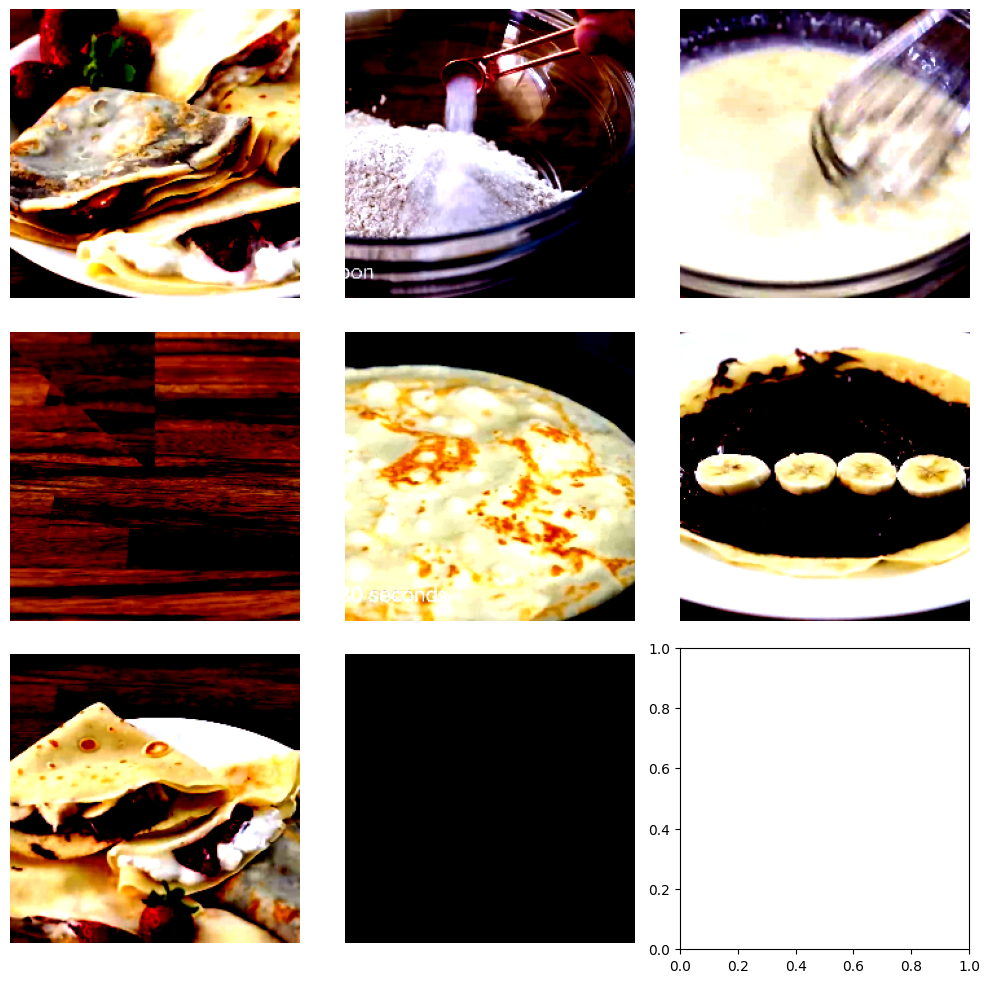

ASSISTANT: To make a banana crepe, start by mixing milk, flour, and sugar in a bowl. Heat a pan and add butter, then pour the milk mixture into the pan. Cook until the mixture thickens, then add sliced bananas and chocolate sauce. Fold the crepe in half and serve.


In [7]:
#video = './dataset/raw_videos/tartiflette.mp4'
#video = '../delphi-video-to-text-videollava/videollavaproject/videollava/serve/examples/Rugby_Try.mp4'
video = '../delphi-video-to-text-videollava/videollavaproject/videollava/serve/examples/Make_Crepes.mp4'
user_text_input = 'Give the recipe to cook this.'

#segments = [[x, x] for x in np.linspace(0, 3.44*60, 8, dtype=int)]
#segments = [[x, x] for x in np.linspace(0, 3.02*60, 8, dtype=int)]
segments = [[21,21], [24,24], [40,40], [47,47], [59,59], [87,87], [100,100], [123,123]]


input_ids, output_ids = single_video_generation(model, 
                                                video_processor, 
                                                user_text_input, 
                                                video, 
                                                max_new_tokens=200, 
                                                do_sample=False, 
                                                segments=segments, 
                                                display_images=True,
                                                use_cache=True,
                                                )
outputs = tokenizer.decode(output_ids[0, input_ids.shape[1]:], skip_special_tokens=True).strip()
print(f"ASSISTANT: {outputs}")